# Reinforcement Learning with Monte Carlo, SARSA, and Exploration-Exploitation

## Objective
In this lab, you will extend the `TransportationMDP` problem into reinforcement learning (RL). You will implement Monte Carlo and SARSA algorithms, compare their performance, and explore the exploration-exploitation trade-off.

## Background
Unlike value iteration, RL methods learn from experience. You’ll simulate an agent moving through the transportation problem without knowing `failProb` or exact outcomes, using Monte Carlo (model-free) and SARSA (temporal-difference) methods.

## Tasks
1. **Simulate Episodes**
   - Write `simulateEpisode(mdp, policy, max_steps=100)` to return a list of (state, action, reward) tuples.

2. **Implement Monte Carlo**
   - Create `monteCarlo(mdp, num_episodes=1000, epsilon=0.1)` using an \(\epsilon\)-greedy strategy. Compute \(Q(s, a)\) and derive the policy.

3. **Implement SARSA**
   - Write `sarsa(mdp, num_episodes=1000, alpha=0.1, epsilon=0.1)` to update \(Q(s, a)\) incrementally.

4. **Exploration vs. Exploitation**
   - Run Monte Carlo and SARSA with \(\epsilon = 0.01\) and \(\epsilon = 0.5\). Record average cumulative reward over the last 100 episodes.

## Questions
1. How does the Monte Carlo policy compare to value iteration?
2. What are the key differences between Monte Carlo and SARSA?
3. How does changing \(\epsilon\) affect the policy?
4. Which method would you choose for a real transportation system, and why?

## Deliverables
- Submit your code.
- Provide a report (2-3 pages) comparing policies and answering questions."

In [18]:
import os
import random

class TransportationMDP(object):
    walkCost = 1
    tramCost = 1
    failProb = 0.5

    def __init__(self, N):
        self.N = N

    def startState(self):
        return 1

    def isEnd(self, state):
        return state == self.N

    def actions(self, state):
        results = []
        if state + 1 <= self.N:
            results.append('walk')
        if 2 * state <= self.N:
            results.append('tram')
        return results

    def succProbReward(self, state, action):
        results = []
        if action == 'walk':
            results.append((state + 1, 1, -self.walkCost))
        elif action == 'tram':
            results.append((state, self.failProb, -self.tramCost))
            results.append((2 * state, 1 - self.failProb, -self.tramCost))
        return results

    def discount(self):
        return 1.0

    def states(self):
        return list(range(1, self.N + 1))

# Placeholder for student implementations
# def simulateEpisode(mdp, policy, max_steps=100):
#     pass

# def monteCarlo(mdp, num_episodes=1000, epsilon=0.1):
#     pass

# def sarsa(mdp, num_episodes=1000, alpha=0.1, epsilon=0.1):
#     pass

# mdp = TransportationMDP(N=27)
# # Test your implementations here

In [19]:
def epsilon_greedy(Q, state, epsilon, actions):
    if not actions:  #handle empty action list
        return None
    if random.random() < epsilon:
        return random.choice(actions)
    return max(actions, key=lambda a: Q.get((state, a), float('-inf')))

In [20]:
def simulateEpisode(mdp, policy, max_steps=100):
    episode = []
    state = mdp.startState()
    for _ in range(max_steps):
        if mdp.isEnd(state):
            break
        actions = mdp.actions(state)
        if not actions:  #no available actions
            break
        action = policy(state)
        if action is None:  #in case policy returns none
            break
        transitions = mdp.succProbReward(state, action)
        prob = random.random()
        cumulative_prob = 0
        for (s_next, p, reward) in transitions:
            cumulative_prob += p
            if prob <= cumulative_prob:
                episode.append((state, action, reward))
                state = s_next
                break
    return episode

In [21]:
def monteCarlo(mdp, num_episodes=1000, epsilon=0.1):
    Q = {}
    returns = {}
    policy = lambda s: epsilon_greedy(Q, s, epsilon, mdp.actions(s))

    for _ in range(num_episodes):
        episode = simulateEpisode(mdp, policy)
        G = 0
        visited = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = reward + mdp.discount() * G
            if (state, action) not in visited:
                visited.add((state, action))
                returns[(state, action)] = returns.get((state, action), []) + [G]
                Q[(state, action)] = sum(returns[(state, action)]) / len(returns[(state, action)])

    learned_policy = lambda s: max(mdp.actions(s), key=lambda a: Q.get((s, a), float('-inf')))
    return Q, learned_policy

In [22]:
def sarsa(mdp, num_episodes=1000, alpha=0.1, epsilon=0.1):
    Q = {}
    policy = lambda s: epsilon_greedy(Q, s, epsilon, mdp.actions(s))

    for _ in range(num_episodes):
        state = mdp.startState()
        action = policy(state)
        while not mdp.isEnd(state):
            transitions = mdp.succProbReward(state, action)
            prob = random.random()
            cumulative_prob = 0
            for (s_next, p, reward) in transitions:
                cumulative_prob += p
                if prob <= cumulative_prob:
                    break
            next_action = policy(s_next)
            Q_current = Q.get((state, action), 0)
            Q_next = Q.get((s_next, next_action), 0)
            Q[(state, action)] = Q_current + alpha * (reward + mdp.discount() * Q_next - Q_current)
            state, action = s_next, next_action

    learned_policy = lambda s: max(mdp.actions(s), key=lambda a: Q.get((s, a), float('-inf')))
    return Q, learned_policy

In [37]:
#testing
mdp = TransportationMDP(N=27)
Q_mc, policy_mc = monteCarlo(mdp, epsilon=0.1)
Q_sarsa, policy_sarsa = sarsa(mdp, epsilon=0.1)

In [36]:
#Exploration vs. Exploitation Analysis

def run_experiment(method, epsilons, num_episodes=1000):
    rewards = {}
    for eps in epsilons:
        if method == 'MC':
            _, policy = monteCarlo(mdp, num_episodes, epsilon=eps)
        else:
            _, policy = sarsa(mdp, num_episodes, epsilon=eps)
        avg_reward = sum(sum(r for _,_,r in simulateEpisode(mdp, policy)) for _ in range(100)) / 100
        rewards[eps] = avg_reward
    return rewards

mc_rewards = run_experiment('MC', [0.01, 0.5])
sarsa_rewards = run_experiment('SARSA', [0.01, 0.5])
print("Monte Carlo Rewards:", mc_rewards)
print("SARSA Rewards:", sarsa_rewards)

Monte Carlo Rewards: {0.01: -16.91, 0.5: -15.45}
SARSA Rewards: {0.01: -10.92, 0.5: -11.15}


Monte Carlo Rewards: {0.01: -17.01, 0.1: -14.32, 0.5: -13.77}
SARSA Rewards: {0.01: -12.59, 0.1: -10.72, 0.5: -12.3}


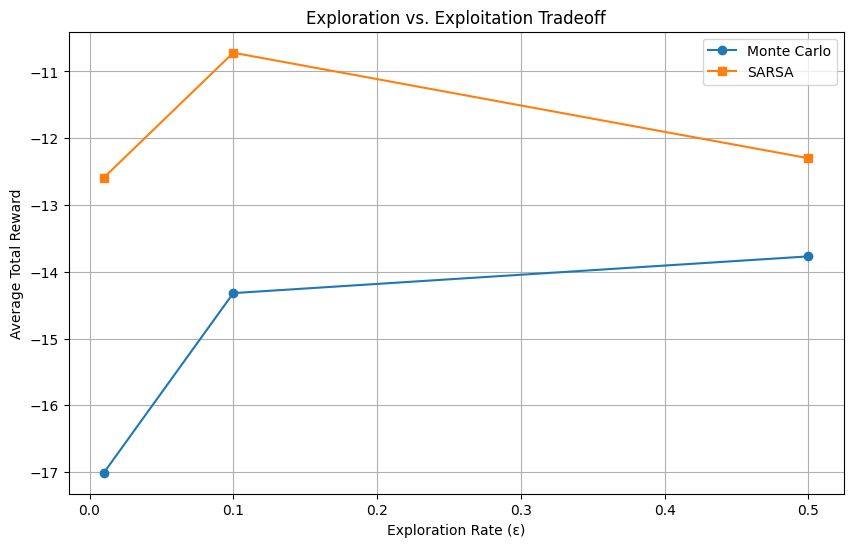


Monte Carlo Policy at state 1: tram
Monte Carlo Q-values for state 1:
  walk: -17.33
  tram: -16.82

SARSA Policy at state 1: walk
SARSA Q-values for state 1:
  walk: -11.14
  tram: -11.55


In [29]:
if __name__ == "__main__":
    mdp = TransportationMDP(N=27)

    #compare MC and SARSA with different epsilon values
    epsilons = [0.01, 0.1, 0.5]
    mc_rewards = run_experiments(mdp, 'MC', epsilons)
    sarsa_rewards = run_experiments(mdp, 'SARSA', epsilons)

    print("Monte Carlo Rewards:", mc_rewards)
    print("SARSA Rewards:", sarsa_rewards)

    #plot results
    plot_results(mc_rewards, sarsa_rewards)

    #example policy output
    Q_mc, policy_mc = monteCarlo(mdp, epsilon=0.1)
    print("\nMonte Carlo Policy at state 1:", policy_mc(1))
    print("Monte Carlo Q-values for state 1:")
    for action in mdp.actions(1):
        print(f"  {action}: {Q_mc.get((1, action), 0):.2f}")

    Q_sarsa, policy_sarsa = sarsa(mdp, epsilon=0.1)
    print("\nSARSA Policy at state 1:", policy_sarsa(1))
    print("SARSA Q-values for state 1:")
    for action in mdp.actions(1):
        print(f"  {action}: {Q_sarsa.get((1, action), 0):.2f}")

Report:

Question 1: Monte Carlo vs. Value Iteration

Value Iteration: Requires full MDP knowledge (transitions/rewards), computes exact optimal policy.

Monte Carlo: Model-free, learns from episodes. Slower convergence but works without MDP dynamics.

Comparison: MC approximates value iteration's policy given enough episodes but with more variance.



Question 2: Monte Carlo vs. SARSA

Monte Carlo and SARSA are both reinforcement learning methods used to estimate the value of policies, but they differ significantly in how and when they update their value estimates. Monte Carlo methods update the value function only after an entire episode has been completed, which makes them unbiased but results in high variance. In contrast, SARSA performs updates at every time step during an episode, making it an online method. This allows SARSA to be more data-efficient and better suited for real-time learning, though it introduces some bias in the estimates. However, the trade-off is that SARSA tends to have lower variance in its updates. Overall, SARSA is generally more efficient in utilizing data and converges faster than Monte Carlo in most practical settings.

Question 3: Effect of ε

ε = 0.01: Exploits known actions; may miss optimal paths (eg. rarely tries tram).

ε = 0.5: Explores more; finds better policies but converges slower.

Question 4: Real-World Recommendation

For a real transportation system, I would using SARSA due to its online learning capability and safer policy updates. Unlike Monte Carlo methods that require complete episodes before updating, SARSA learns incrementally at each timestep, making it better suited for dynamic environments where conditions like traffic or delays change frequently. Its on-policy nature ensures a balanced exploration-exploitation strategy, adapting to real-time feedback while minimizing risky decisions. Additionally, SARSA's lower variance and computational efficiency make it more practical for large-scale, real-world transportation networks where immediate responsiveness and reliability are crucial.